In [106]:
#todo: Windstaerke und richtung

In [107]:
from urllib.parse import urljoin
import requests

import pandas as pd
import numpy as np

import datetime
from zoneinfo import ZoneInfo
import ephem
import pytz

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import matplotlib.ticker as ticker

from scipy.signal import find_peaks

In [108]:
url='https://www.pegelonline.wsv.de/webservices/rest-api/v2/'

In [109]:
response = requests.get(urljoin(url, 'stations.json'))
response.raise_for_status()

In [110]:
name='EIDER-SPERRWERK AP'
record=[r for r in response.json() if r['shortname'] == name][0]
uuid=record['uuid']

In [111]:
localtz=ZoneInfo("Europe/Berlin")
utc = ZoneInfo('UTC')
start=datetime.datetime(2021, 1, 1, tzinfo=localtz)
#start=datetime.datetime(2021, 12, 20, tzinfo=localtz)
end=datetime.datetime.now(tz=localtz)

In [ ]:

# load all data sets (or just write them to database)

In [162]:
response = requests.get(urljoin(url, f'stations/{uuid}/W/measurements.json?start={start.isoformat()}&end={end.isoformat()}'))
response.raise_for_status()
df = pd.DataFrame(response.json()).set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [181]:
df_old = pd.read_csv('tilde_2021-11-24T00:01:00+01:00-2021-12-25T15:16:00+01:00.csv', parse_dates = ['timestamp'])
df = pd.concat([
    df.reset_index(), 
    df_old
]).drop_duplicates().set_index('timestamp').sort_index()

In [164]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
value,46953.0,517.019914,106.991222,248.0,423.0,538.0,606.0,759.0


In [165]:
from math import radians as rad,degrees as deg  

# https://michelanders.blogspot.com/2011/01/moon-phases-with-pyephem.html
g = ephem.Observer()  
g.name=name  
g.lat=rad(record['latitude']) 
g.long=rad(record['longitude'])  
m = ephem.Moon()  
m.compute(g)

def get_moons_phases(start_date, end_date):
    """Returns a list of the full and new moons in a year. The list contains tuples of either the form (DATE,'full') or the form (DATE,'new')"""
    
    date=start_date
    moons=[]
    while date<end_date:
        date=ephem.next_full_moon(ephem.Date(date)).datetime().replace(tzinfo=datetime.timezone.utc)
        if date<=end_date:
            moons.append( (date, '$\u25CB$') )

    date=start_date
    while date<end_date:
        date=ephem.next_new_moon(ephem.Date(date)).datetime().replace(tzinfo=datetime.timezone.utc)
        if date<=end_date:
            moons.append( (date, '$\u25CF$') )
            
    date=start_date
    while date<end_date:
        date=ephem.next_first_quarter_moon(ephem.Date(date)).datetime().replace(tzinfo=datetime.timezone.utc)
        if date<=end_date:
            moons.append( (date, '$\u263D$') )
            
    date=start_date
    while date<end_date:
        date=ephem.next_last_quarter_moon(ephem.Date(date)).datetime().replace(tzinfo=datetime.timezone.utc)
        if date<=end_date:
            moons.append( (date, '$\u263E$') )

    moons.sort(key=lambda x: x[0])

    return moons

phases = get_moons_phases(df.index.min(), df.index.max())
phases = {
    mdates.date2num(d.astimezone(localtz)): p 
    for d, p in phases
}


In [166]:
# Formater
def meter_formater(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e2:
        s = '{:1.2f}m'.format(x*1e-2)
    else:
        s = '{:1.0f}cm'.format(x)
    return s

def moon_formater(x, pos):
    return phases[x]


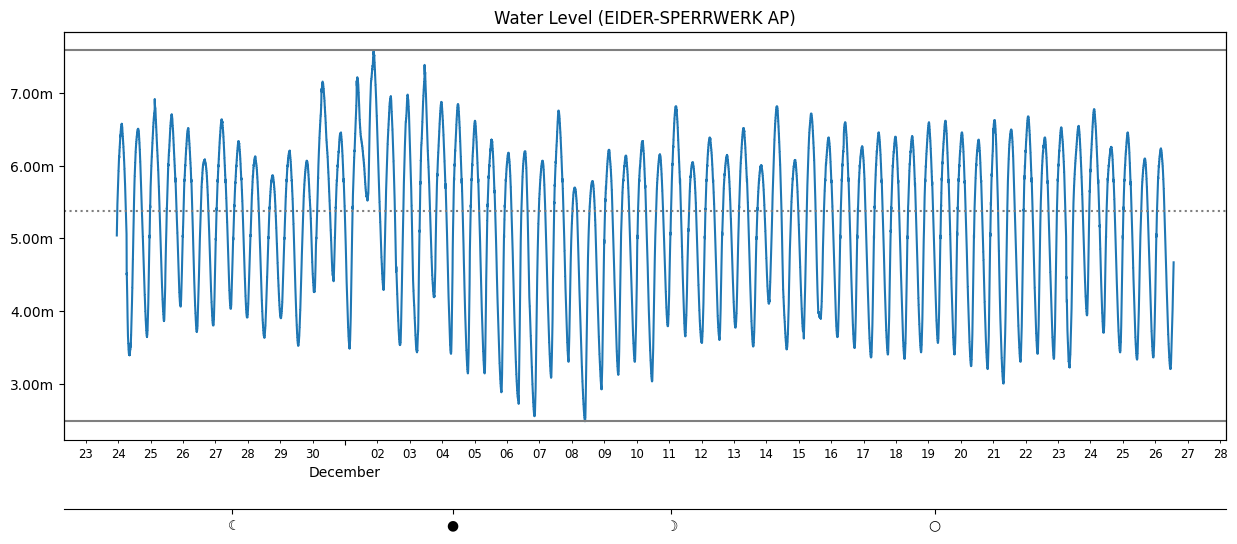

In [174]:
#import matplotlib
#matplotlib.rc('font', family='Symbola')
fig, ax = plt.subplots(dpi=100, figsize=(15,6))
df.plot(ax=ax)

ax.set_title(f"Water Level ({name})")

# set y axis
ax.yaxis.set_major_formatter(meter_formater)

# set x axis 1
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.tick_params(axis='x', which='minor', rotation=0)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.tick_params(axis='x', which='major', rotation=90)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
for label in ax.get_xmajorticklabels() :
    label.set_rotation(0)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_horizontalalignment('center')
for label in ax.xaxis.get_minorticklabels():
    label.set_fontsize('small')
ax.xaxis.set_tick_params(which='major', pad=15)
ax.set_xlabel('')


# set x axis 2
ax2 = ax.twiny()
ax2.xaxis.set_major_locator(ticker.FixedLocator(list(phases.keys())))
ax2.xaxis.set_major_formatter(moon_formater)
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 50))
ax2.set_xlim(ax.get_xlim())

# legend
ax.legend().remove()

# specific values
ax.axhline(y=df.min().value, color='tab:gray', linestyle='-')
ax.axhline(y=df.median().value, color='tab:gray', linestyle=':')
ax.axhline(y=df.max().value, color='tab:gray', linestyle='-')


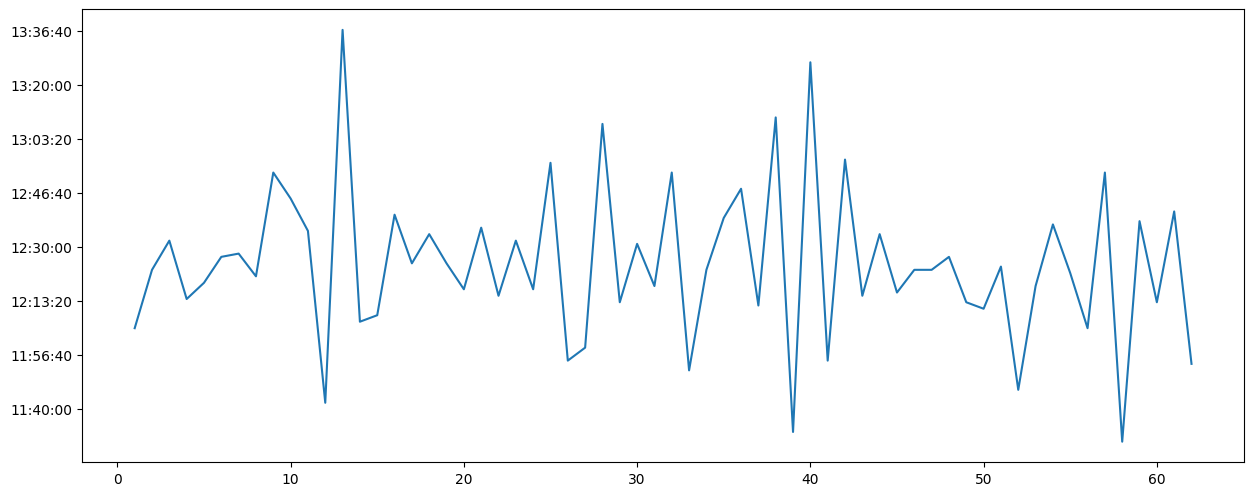

In [186]:

peaks, _ = find_peaks(
    df.rolling(center=True, window=datetime.timedelta(hours=1)).max().value,
    height=0
)


fig, ax = plt.subplots(dpi=100, figsize=(15,6))
(df.iloc[peaks].reset_index()-df.iloc[peaks].reset_index().shift(1))['timestamp'].plot(ax=ax)

def timedelta_formater(x, pos):
    """The two args are the value and tick position"""
    return datetime.timedelta(microseconds=x/10**3)

ax.yaxis.set_major_formatter(timedelta_formater)



In [169]:
df.to_csv(f'tilde_{df.index.min().isoformat()}-{df.index.max().isoformat()}.csv')